In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_selection import mutual_info_classif
from sklearn.base import clone
from xgboost import XGBClassifier

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')

train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [4]:
train_df.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [5]:
train_df['Driving_License'].value_counts()

Driving_License
1    11482041
0       22757
Name: count, dtype: int64

In [6]:
train_df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [7]:
train_df=train_df.drop_duplicates()

In [8]:
train_df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,5.752398e+06,3.838356e+01,9.980220e-01,2.641869e+01,4.629966e-01,3.046137e+04,1.124254e+02,1.638977e+02,1.229973e-01
std,3.321149e+06,1.499346e+01,4.443120e-02,1.299159e+01,4.986289e-01,1.645475e+04,5.403571e+01,7.997953e+01,3.284341e-01
min,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,2.876199e+06,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.527700e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,5.752398e+06,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,8.628598e+06,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.945100e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,1.150480e+07,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


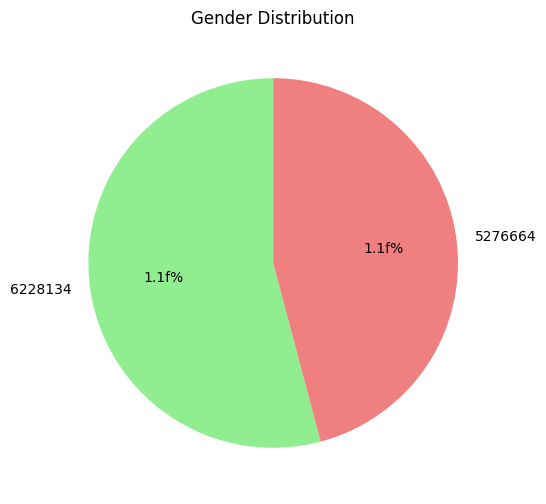

In [9]:
gender_counts = train_df['Gender'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(gender_counts, labels=gender_counts, autopct='1.1f%%', colors=['lightgreen', 'lightcoral'], startangle=90)
plt.title('Gender Distribution')
plt.show()

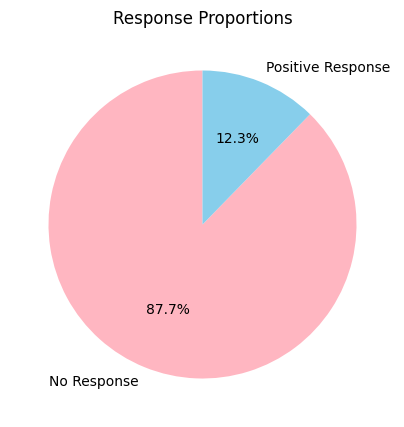

In [10]:
response_counts = train_df['Response'].value_counts()
plt.figure(figsize=(5,5))
plt.pie(response_counts, labels=['No Response', 'Positive Response'], autopct = '%1.1f%%', colors =['lightpink', 'skyblue'], startangle=90)
plt.title('Response Proportions')
plt.show()

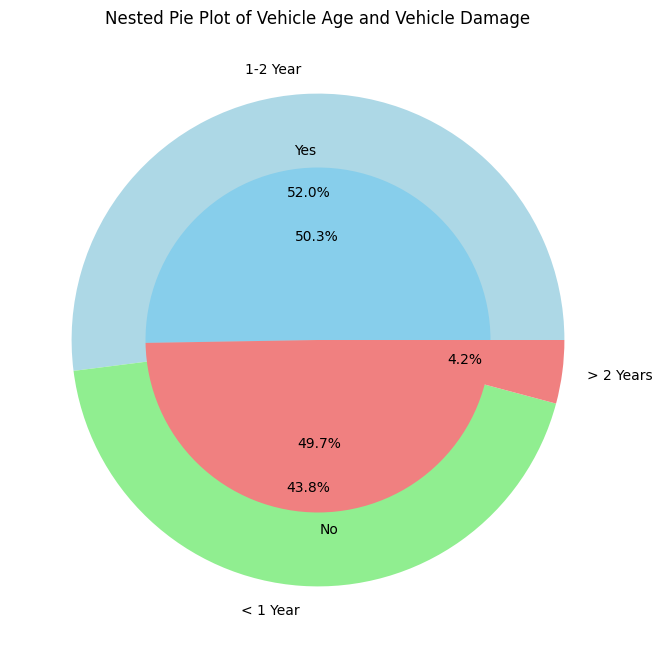

In [11]:
vehicle_age_counts = train_df['Vehicle_Age'].value_counts()
vehicle_damage_counts = train_df['Vehicle_Damage'].value_counts()

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(vehicle_age_counts, labels=vehicle_age_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightcoral'], radius=1)
ax.pie(vehicle_damage_counts, labels=vehicle_damage_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], radius=0.7)
ax.set(aspect="equal", title='Nested Pie Plot of Vehicle Age and Vehicle Damage')
plt.show()

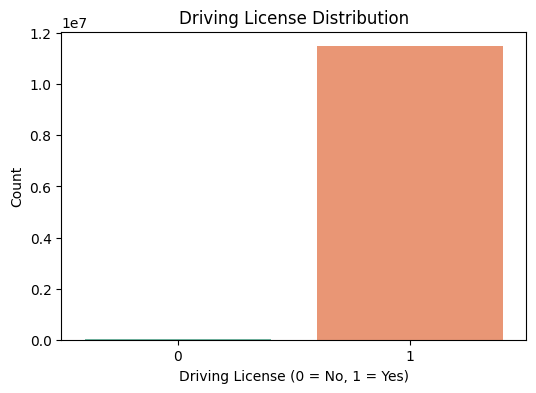

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Driving_License', data=train_df, palette='Set2')
plt.title('Driving License Distribution')
plt.xlabel('Driving License (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

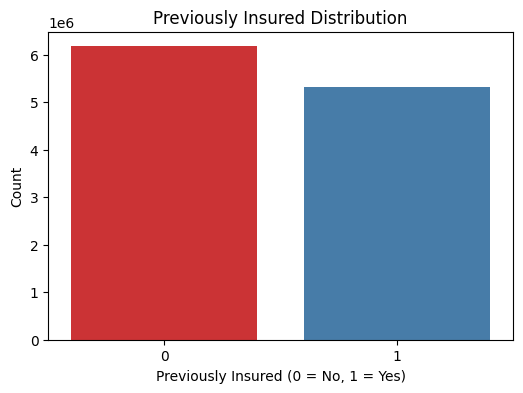

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Previously_Insured', data=train_df, palette='Set1')
plt.title('Previously Insured Distribution')
plt.xlabel('Previously Insured (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

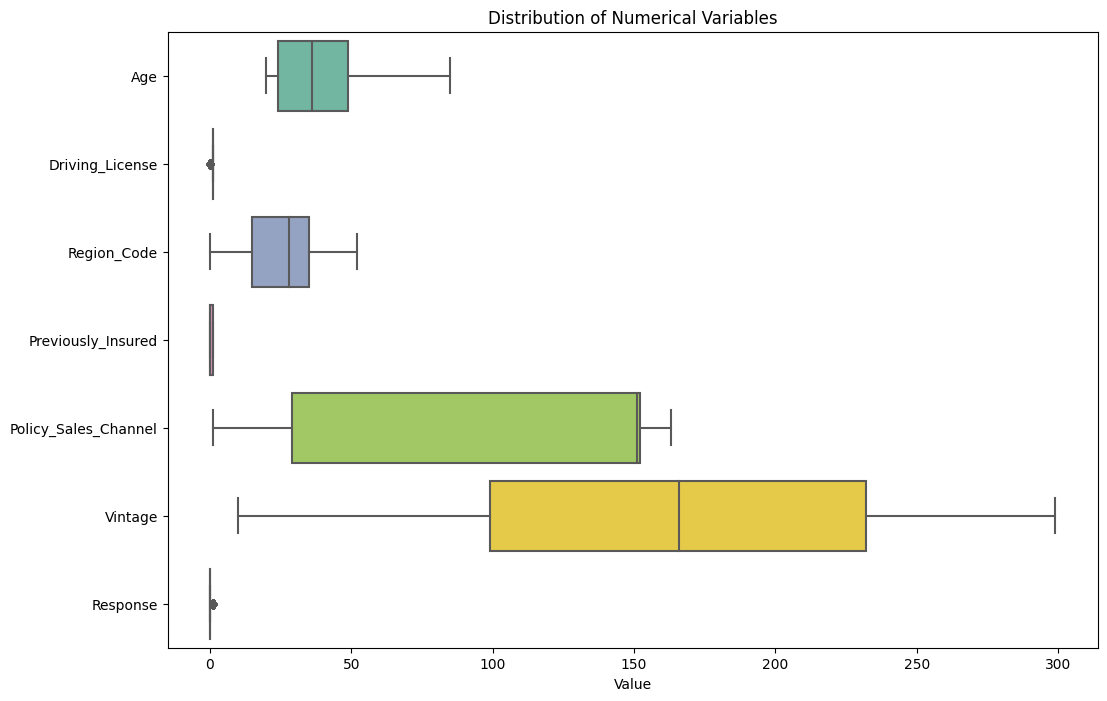

In [14]:
numerical_cols = ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 
                  'Policy_Sales_Channel', 'Vintage', 'Response']
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_df[numerical_cols], orient='h', palette='Set2')
plt.title('Distribution of Numerical Variables')
plt.xlabel('Value')
plt.show()

In [15]:
train_df = train_df.drop('id', axis = 1)
num_cols = list(train_df.select_dtypes(exclude=['object']).columns.difference(['Response']))
cat_cols = list(train_df.select_dtypes(include=['object']).columns)

num_cols_test = list(test_df.select_dtypes(exclude=['object']).columns.difference(['id']))
cat_cols_test = list(test_df.select_dtypes(include=['object']).columns)


In [16]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
le = LabelEncoder()

for col_name in train_df.columns:
    if train_df[col_name].dtypes=='object':
        train_df[col_name]=le.fit_transform(train_df[col_name])
        test_df[col_name]=le.fit_transform(test_df[col_name])
    
scaler = StandardScaler()

train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols_test] = scaler.transform(test_df[num_cols_test])

Response                1.000000
Vehicle_Damage          0.359780
Age                     0.122134
Gender                  0.055212
Annual_Premium          0.032261
Region_Code             0.012816
Driving_License         0.009197
Vintage                -0.015177
Vehicle_Age            -0.111630
Policy_Sales_Channel   -0.152733
Previously_Insured     -0.345930
Name: Response, dtype: float64


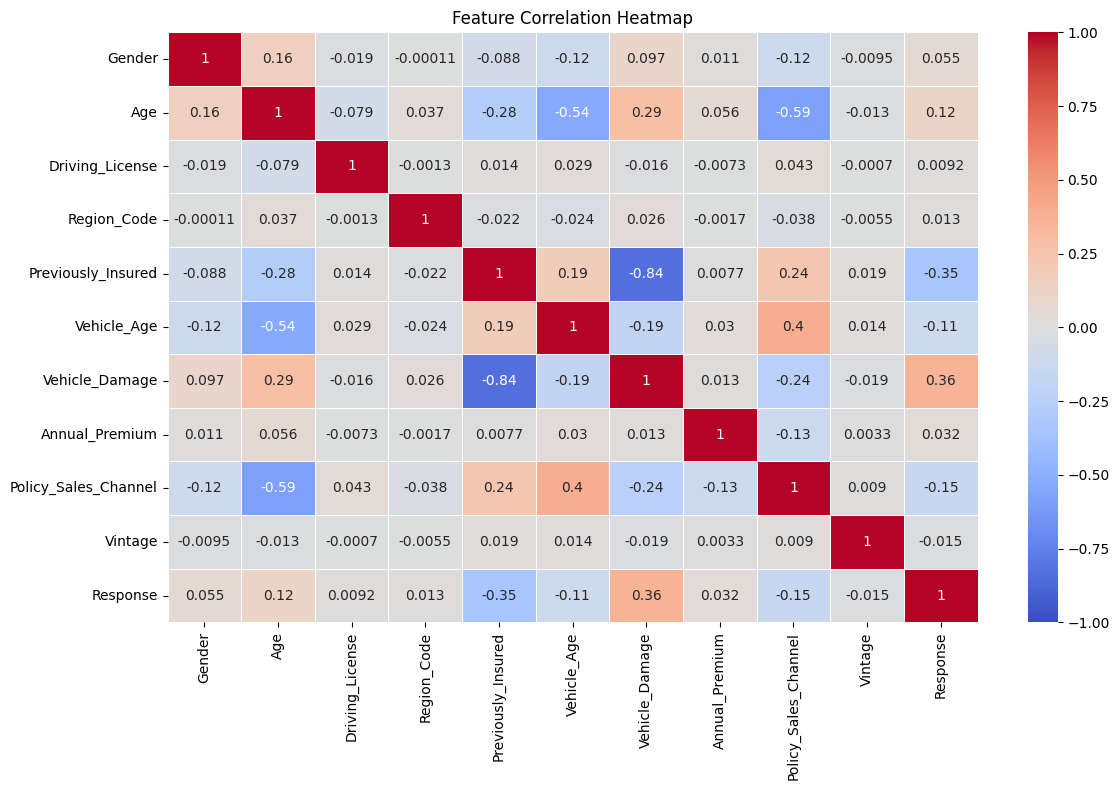

In [17]:
corr_matrix= train_df.corr()

traget_corr = corr_matrix['Response'].sort_values(ascending=False)

print(traget_corr)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [18]:
X = train_df.drop(columns=['Response'])
y = train_df['Response']

test = test_df.drop(['id'], axis =1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
#train the model
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
y_prediction = model.predict_proba(X_val)[:,1]

print('AUC-ROC: ', roc_auc_score(y_val, y_prediction))

AUC-ROC:  0.8782267398445096


In [21]:
pred = model.predict_proba(test)[:,1]

submission = pd.DataFrame({'id': test_df.id, 'Response': pred})
submission.to_csv('submission.csv', index =False)
submission.head()

,id,Response
0,11504798,0.006195
1,11504799,0.453228
2,11504800,0.241959
3,11504801,0.000126
4,11504802,0.038496
